- mu_I only zero for # e- = 0
- no frozen core approximation/pseudopotentials (pp only for pbc)
- h_core in code = e_kin + e_nuc_e


- N2 as reference system: E(\lambda) = diatomics from H2 to N2 (no basis set, core potential etc. problem)
- N2 from diatomics 3.56 Ha to low, N2 from APDFT implementation differs 230mH from N2 from diatomics

- N2 mean of lumo homo very close to N2 reference (coincidence, for qm9 molecule both are bad)

- deviation from true energy might be systematic -> could be corrected by using atomisation energies where energies of atoms are calculated from alchemy

In [1]:
import numpy as np
import scipy as sc
import numpy
import pyscf
import pyscf.gto
import pyscf.qmmm
import pyscf.scf
import pyscf.dft
import pyscf.lib
from pyscf.data import nist
import qml

angstrom = 1 / 0.52917721067

In [ ]:
np.arange(0, 54, 2)

In [2]:
com = qml.Compound(xyz='/home/misa/datasets/qm9/dsgdb9nsd_001212.xyz')
total_elec = com.nuclear_charges.sum()
num_elecs = np.arange(0, 54, 2)#[22, 30, 38, 44, 52]
alchemical_potentials = []
e_homo = []
e_lumo = []

for num_elec in num_elecs:
    print(f'Calculating {num_elec}')
    lam_val = num_elec/total_elec
    # core_elec = com.nuclear_charges.sum() - total_num_ve

    mol = pyscf.gto.Mole()
    for ch, coords in zip(com.nuclear_charges, com.coordinates):
        mol.atom.append([ch, coords])

    mol.basis = 'def2-tzvp'
    print(total_elec - num_elec)
    mol.charge = total_elec - num_elec
#     mol.nelectron = num_elec
    mol.verbose = 4
    mol.build()

    method = "HF"
    if method not in ["CCSD", "HF"]:
        raise NotImplementedError("Method %s not supported." % method)

    deltaZ = com.nuclear_charges*(1-lam_val)
    includeonly = np.arange(len(mol.atom_coords()))


    def add_qmmm(calc, mol, deltaZ):
        mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords()[includeonly]/ angstrom, deltaZ)

        def energy_nuc(self):
            q = mol.atom_charges().astype(np.float)
            q[includeonly] += deltaZ
            return mol.energy_nuc(q)

        mf.energy_nuc = energy_nuc.__get__(mf, mf.__class__)

        return mf

    if method == "HF":
        calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
        hfe = calc.kernel(verbose=0)
        dm1_ao = calc.make_rdm1()
        total_energy = calc.e_tot
    if method == "CCSD":
        calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
        hfe = calc.kernel(verbose=0)
        mycc = pyscf.cc.CCSD(calc).run()
        dm1 = mycc.make_rdm1()
        dm1_ao = np.einsum("pi,ij,qj->pq", calc.mo_coeff, dm1, calc.mo_coeff.conj())
        total_energy = mycc.e_tot

    # GRIDLESS, as things should be ############################
    # Total energy of SCF run

    print("TOTAL_ENERGY", total_energy)

    # Electronic EPN from electron density
    alch_pot_tmp = []
    for site in includeonly:
        mol.set_rinv_orig_(mol.atom_coords()[site])
#         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
        alch_pot_tmp.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
    alchemical_potentials.append(alch_pot_tmp)
    
    # energy of HOMO and LUMO
    nocc = int((total_elec - mol.charge)/2)
    e_homo.append(calc.mo_energy[nocc-1])
    e_lumo.append(calc.mo_energy[nocc])

Calculating 0
52
System: uname_result(system='Linux', node='pc-avl24', release='4.15.0-108-generic', version='#109-Ubuntu SMP Fri Jun 19 11:33:10 UTC 2020', machine='x86_64', processor='x86_64')  Threads 8
Python 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy 1.16.4  scipy 1.2.1
Date: Wed Jul  8 10:38:51 2020
PySCF version 1.7.1
PySCF path  /home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 12
[INPUT] num. electrons = 0
[INPUT] charge = 52
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT]  1 C     -0.136883959200   1.448579793000   0.011368940800 AA   -0.258673193734   2.737419078349   0.021484184438 Bohr
[INPUT]  2 C      0.064357729200  -0.043732595200   0.001817971000 AA    0.121618482187  -0.082642627644   0.003435467292 Bohr
[INPUT]  3 O      1.114424575900  -0.629340888600  -0.012303871000 AA    2.105957234936  -1

Overwritten attributes  energy_nuc  of <class 'pyscf.qmmm.itrf.qmmm_for_scf.<locals>.QMMM'>


init E= -930.337621146837

WARN: HOMO -5.89265058373373 == LUMO -118.747318440967



/home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/pyscf/gto/mole.py:1047: UserWarning: Function mol.dumps drops attribute charge because it is not JSON-serializable
  warnings.warn(msg)


cycle= 1 E= 1090.12179882041  delta_E= 2.02e+03  |g|=    0  |ddm|= 5.31

WARN: HOMO -12.5049612878666 == LUMO -143.633455203328

cycle= 2 E= 1090.12179882041  delta_E=    0  |g|=    0  |ddm|=    0

WARN: HOMO -12.5049612878666 == LUMO -143.633455203328

Extra cycle  E= 1090.12179882041  delta_E=    0  |g|=    0  |ddm|=    0
converged SCF energy = 1090.12179882041
TOTAL_ENERGY 1090.1217988204087
Calculating 2
50
System: uname_result(system='Linux', node='pc-avl24', release='4.15.0-108-generic', version='#109-Ubuntu SMP Fri Jun 19 11:33:10 UTC 2020', machine='x86_64', processor='x86_64')  Threads 8
Python 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy 1.16.4  scipy 1.2.1
Date: Wed Jul  8 10:38:59 2020
PySCF version 1.7.1
PySCF path  /home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 12
[INPUT] num. electrons = 2
[INPUT] charge = 50
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symme

cycle= 39 E= 785.836027205383  delta_E= 7.14  |g|= 2.31  |ddm|= 3.97
  HOMO = -138.619977658098  LUMO = -127.288476784241
cycle= 40 E= 778.700353417872  delta_E= -7.14  |g|= 2.38  |ddm|= 3.97
  HOMO = -138.25617934152  LUMO = -127.65068678566
cycle= 41 E= 778.697454270864  delta_E= -0.0029  |g|= 2.27  |ddm|= 0.00655
  HOMO = -133.675442516944  LUMO = -132.225941067355
cycle= 42 E= 785.827534313811  delta_E= 7.13  |g|= 1.96  |ddm|= 3.95
  HOMO = -135.465570467069  LUMO = -130.441770360002
cycle= 43 E= 785.841207409988  delta_E= 0.0137  |g|=  2.5  |ddm|= 0.0301
  HOMO = -137.868341861724  LUMO = -128.05241253813
cycle= 44 E= 785.864521541909  delta_E= 0.0233  |g|= 3.21  |ddm|= 0.0404
  HOMO = -144.865088324262  LUMO = -121.092785950179
cycle= 45 E= 778.770312456524  delta_E= -7.09  |g|= 4.23  |ddm|= 4.06
  HOMO = -136.044973562529  LUMO = -129.865035059993
cycle= 46 E= 785.84631306766  delta_E= 7.08  |g|= 2.67  |ddm|= 4.05
  HOMO = -136.018496949754  LUMO = -129.881744550484
cycle= 47 E=

cycle= 1 E= 283.086944891562  delta_E= 1.18e+03  |g|= 2.79  |ddm|= 6.62
  HOMO = -90.3767916597619  LUMO = -83.3024344742995
cycle= 2 E= 283.033995247443  delta_E= -0.0529  |g|= 0.0896  |ddm|= 0.131
  HOMO = -90.3505858018016  LUMO = -83.3024116301495
cycle= 3 E= 283.033939616361  delta_E= -5.56e-05  |g|= 0.000241  |ddm|= 0.00443
  HOMO = -90.3505372318646  LUMO = -83.3024121515185
cycle= 4 E= 283.03393961597  delta_E= -3.91e-10  |g|= 4.55e-06  |ddm|= 2.13e-05
  HOMO = -90.3505350276819  LUMO = -83.3024121512648
Extra cycle  E= 283.033939615969  delta_E= -3.41e-13  |g|= 1.6e-07  |ddm|= 2.67e-07
converged SCF energy = 283.033939615969
TOTAL_ENERGY 283.0339396159693
Calculating 8
44
System: uname_result(system='Linux', node='pc-avl24', release='4.15.0-108-generic', version='#109-Ubuntu SMP Fri Jun 19 11:33:10 UTC 2020', machine='x86_64', processor='x86_64')  Threads 8
Python 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy 1.16.4  scipy 1.2.1
Date: Wed Jul  8 10:42:25 2020
PySCF

  HOMO = -79.5366949018534  LUMO = -75.9812191926571
cycle= 38 E= 112.391432629286  delta_E= -3.7  |g|= 1.61  |ddm|= 4.08
  HOMO = -77.9660893451354  LUMO = -76.1019949976542
cycle= 39 E= 112.375665523153  delta_E= -0.0158  |g|=  1.1  |ddm|= 0.0727
  HOMO = -76.5187550892141  LUMO = -76.4352355322107
cycle= 40 E= 112.350813043675  delta_E= -0.0249  |g|= 0.713  |ddm|= 0.178
  HOMO = -76.8492030639377  LUMO = -76.2454250643464
cycle= 41 E= 116.085706802757  delta_E= 3.73  |g|= 1.32  |ddm|= 3.98
  HOMO = -77.6635860535025  LUMO = -76.1255384407991
cycle= 42 E= 112.373325821913  delta_E= -3.71  |g|=    1  |ddm|= 4.01
  HOMO = -76.8881918422168  LUMO = -76.2484423153336
cycle= 43 E= 116.084807029219  delta_E= 3.71  |g|= 1.34  |ddm|= 4.01
  HOMO = -76.522903885449  LUMO = -76.4312540608148
cycle= 44 E= 116.0541222185  delta_E= -0.0307  |g|= 1.38  |ddm|= 0.138
  HOMO = -76.5351601742879  LUMO = -76.4191627193044
cycle= 45 E= 115.827176114928  delta_E= -0.227  |g|= 2.26  |ddm|= 0.345
  HOMO = 

  HOMO = -75.044192228374  LUMO = -68.0332935427409
cycle= 30 E= -42.6281249579074  delta_E= -14.3  |g|= 2.57  |ddm|= 7.63
  HOMO = -71.7203111713749  LUMO = -71.6048260537064
cycle= 31 E= -28.3454715011844  delta_E= 14.3  |g|= 2.63  |ddm|= 7.64
  HOMO = -74.4105392317876  LUMO = -68.6399838354673
cycle= 32 E= -42.6435633255792  delta_E= -14.3  |g|=  2.3  |ddm|= 7.62
  HOMO = -71.4923147003766  LUMO = -71.4343232354702
cycle= 33 E= -38.7995476166707  delta_E= 3.84  |g|= 1.47  |ddm|= 6.42
  HOMO = -71.7662795491293  LUMO = -71.3012410736137
cycle= 34 E= -38.6300549633283  delta_E= 0.169  |g|= 4.02  |ddm|=  1.2
  HOMO = -72.740417179359  LUMO = -70.5735117294295
cycle= 35 E= -28.3205674171686  delta_E= 10.3  |g|=    3  |ddm|= 3.86
  HOMO = -71.5462322343281  LUMO = -71.5088871197171
cycle= 36 E= -38.7843305468465  delta_E= -10.5  |g|= 2.17  |ddm|= 3.88
  HOMO = -71.4983996887747  LUMO = -71.3891300220442
cycle= 37 E= -38.8001768597495  delta_E= -0.0158  |g|= 1.36  |ddm|= 0.222
  HOMO = -

  HOMO = -66.6717627432258  LUMO = -66.3994964885144
cycle= 22 E= -179.141604444972  delta_E= 0.00411  |g|= 1.32  |ddm|= 0.058
  HOMO = -66.7479411078716  LUMO = -66.6973920606012
cycle= 23 E= -175.464958059016  delta_E= 3.68  |g|= 1.45  |ddm|= 5.56
  HOMO = -66.7313622604617  LUMO = -66.7168231834719
cycle= 24 E= -175.559041236796  delta_E= -0.0941  |g|= 1.86  |ddm|= 0.296
  HOMO = -66.7097286231326  LUMO = -66.5158338498411
cycle= 25 E= -179.143300168749  delta_E= -3.58  |g|= 1.28  |ddm|= 5.54
  HOMO = -66.5437014190915  LUMO = -64.8558916928013
cycle= 26 E= -179.121332762139  delta_E= 0.022  |g|= 1.85  |ddm|= 0.0644
  HOMO = -66.6832306725571  LUMO = -63.5353322802941
cycle= 27 E= -181.693763756483  delta_E= -2.57  |g|= 1.99  |ddm|=    6
  HOMO = -66.8048366627211  LUMO = -63.4091467176252
cycle= 28 E= -181.693766795914  delta_E= -3.04e-06  |g|= 1.99  |ddm|= 0.00459
  HOMO = -66.8505461252279  LUMO = -63.3836405970442
cycle= 29 E= -181.694145402303  delta_E= -0.000379  |g|= 1.98  |d

number of shells = 97
number of NR pGTOs = 362
number of NR cGTOs = 247
basis = def2-tzvp
ecp = {}
CPU time:      6308.24


******** <class 'pyscf.qmmm.itrf.qmmm_for_scf.<locals>.QMMM'> ********
method = QMMM-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/misa/git_repositories/APDFT/prototyping/atomic_energies/analysis/tmpjwxg8ra3
max_memory 4000 MB (current use 160 MB)
** Add background charges for <class 'pyscf.scf.hf.RHF'> **
Set gradient conv threshold to 3.16228e-05
init E= -812.89461227696
  HOMO = -20.3707100856786  LUMO = -19.2158466484451
cycle= 1 E= -364.952257771752  delta_E=  448  |g|= 3.03  |ddm|= 13.1
  HOMO = -31.5131564487166  LUMO = -30.4337619936389
cycle= 2 E= -365.121380194224  delta_E= -0.169  |g|= 0.148  |ddm|= 1.63
  HOMO = -31.49

diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/misa/git_repositories/APDFT/prototyping/atomic_energies/analysis/tmpr1kmfeyt
max_memory 4000 MB (current use 159 MB)
** Add background charges for <class 'pyscf.scf.hf.RHF'> **
Set gradient conv threshold to 3.16228e-05
init E= -775.470829003125
  HOMO = -15.7777910927607  LUMO = -15.5212327675194
cycle= 1 E= -448.958678549678  delta_E=  327  |g|= 2.98  |ddm|= 25.5
  HOMO = -24.1463473378434  LUMO = -22.9972783874019
cycle= 2 E= -449.235220796079  delta_E= -0.277  |g|= 0.186  |ddm|= 5.64
  HOMO = -24.1589653801481  LUMO = -22.9541345575072
cycle= 3 E= -449.238710338986  delta_E= -0.00349  |g|= 0.0241  |ddm|= 0.455
  HOMO = -24.1571365191792  LUMO = -22.950165258306
cycle= 4 E= -449.23882834049  delta_E= -0.000118  |g|= 0.00511  |ddm|= 0.0985
  HOMO = -24.1572746435166  LUMO = -22.9498878351006
cycle= 5 E= -449.

number of shells = 97
number of NR pGTOs = 362
number of NR cGTOs = 247
basis = def2-tzvp
ecp = {}
CPU time:      7500.15


******** <class 'pyscf.qmmm.itrf.qmmm_for_scf.<locals>.QMMM'> ********
method = QMMM-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/misa/git_repositories/APDFT/prototyping/atomic_energies/analysis/tmppu6c90oz
max_memory 4000 MB (current use 171 MB)
** Add background charges for <class 'pyscf.scf.hf.RHF'> **
Set gradient conv threshold to 3.16228e-05
init E= -734.821833306747
  HOMO = -13.4134313870666  LUMO = -12.6524796926561
cycle= 1 E= -494.421858755389  delta_E=  240  |g|= 4.36  |ddm|= 24.8
  HOMO = -19.4458865761387  LUMO = -19.2868771558034
cycle= 2 E= -468.052407746994  delta_E= 26.4  |g|= 5.33  |ddm|= 26.5
  HOMO = -19.1943

  HOMO = -17.6200791917895  LUMO = -17.4513464562046
cycle= 16 E= -517.52446177886  delta_E= -0.00603  |g|= 0.0575  |ddm|= 1.38
  HOMO = -17.6494969655079  LUMO = -17.4275021154234
cycle= 17 E= -517.533094738192  delta_E= -0.00863  |g|= 0.0441  |ddm|= 3.47
  HOMO = -17.6366188340865  LUMO = -17.4313126994177
cycle= 18 E= -517.533448683095  delta_E= -0.000354  |g|= 0.0446  |ddm|= 0.498
  HOMO = -17.647141167909  LUMO = -17.4214326446139
cycle= 19 E= -517.536651603191  delta_E= -0.0032  |g|= 0.0276  |ddm|= 1.81
  HOMO = -17.6564727000907  LUMO = -17.4132388615062
cycle= 20 E= -517.537941504641  delta_E= -0.00129  |g|= 0.0109  |ddm|= 1.16
  HOMO = -17.6571471832165  LUMO = -17.4121889710613
cycle= 21 E= -517.538191604409  delta_E= -0.00025  |g|= 0.00648  |ddm|= 0.454
  HOMO = -17.6566100824252  LUMO = -17.4111520818842
cycle= 22 E= -517.538274638723  delta_E= -8.3e-05  |g|= 0.00391  |ddm|= 0.304
  HOMO = -17.6578224421734  LUMO = -17.4100613349312
cycle= 23 E= -517.538288531965  delta_E= 

  HOMO = -16.1214480445209  LUMO = -15.8324171776149
cycle= 23 E= -529.974144642899  delta_E= -1.63e-10  |g|= 2.8e-06  |ddm|= 0.000344
  HOMO = -16.1214484912984  LUMO = -15.8324172758511
Extra cycle  E= -529.974144642904  delta_E= -4.32e-12  |g|= 2.17e-06  |ddm|= 2.48e-05
converged SCF energy = -529.974144642904
TOTAL_ENERGY -529.9741446429036
Calculating 30
22
System: uname_result(system='Linux', node='pc-avl24', release='4.15.0-108-generic', version='#109-Ubuntu SMP Fri Jun 19 11:33:10 UTC 2020', machine='x86_64', processor='x86_64')  Threads 8
Python 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy 1.16.4  scipy 1.2.1
Date: Wed Jul  8 10:59:28 2020
PySCF version 1.7.1
PySCF path  /home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 12
[INPUT] num. electrons = 30
[INPUT] charge = 22
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angst

number of shells = 97
number of NR pGTOs = 362
number of NR cGTOs = 247
basis = def2-tzvp
ecp = {}
CPU time:     10575.73


******** <class 'pyscf.qmmm.itrf.qmmm_for_scf.<locals>.QMMM'> ********
method = QMMM-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/misa/git_repositories/APDFT/prototyping/atomic_energies/analysis/tmpz6ikanmd
max_memory 4000 MB (current use 166 MB)
** Add background charges for <class 'pyscf.scf.hf.RHF'> **
Set gradient conv threshold to 3.16228e-05
init E= -643.848204646353
  HOMO = -8.53292178022816  LUMO = -8.4072230271579
cycle= 1 E= -529.646573823141  delta_E=  114  |g|= 5.44  |ddm|= 20.1
  HOMO = -12.760422117287  LUMO = -12.537654282481
cycle= 2 E= -507.995382369461  delta_E= 21.7  |g|=  6.8  |ddm|=  104
  HOMO = -12.7059432

  HOMO = -11.3632488351567  LUMO = -11.3031299283802
cycle= 2 E= -475.658167325719  delta_E= 51.1  |g|= 9.73  |ddm|= 95.3
  HOMO = -10.8999113339645  LUMO = -10.8969622275294
cycle= 3 E= -528.757581194998  delta_E= -53.1  |g|= 4.66  |ddm|= 94.2
  HOMO = -11.0032085837596  LUMO = -10.8456788070346
cycle= 4 E= -529.857348414182  delta_E= -1.1  |g|= 4.91  |ddm|= 21.9
  HOMO = -10.9380239302633  LUMO = -10.8234270877451
cycle= 5 E= -533.671512804005  delta_E= -3.81  |g|= 3.17  |ddm|= 16.2
  HOMO = -11.1447859837105  LUMO = -10.9414217367103
cycle= 6 E= -532.148737903452  delta_E= 1.52  |g|= 4.34  |ddm|= 15.2
  HOMO = -11.1772540756353  LUMO = -10.9270325742148
cycle= 7 E= -532.877157544849  delta_E= -0.728  |g|= 4.02  |ddm|= 1.47
  HOMO = -11.1491824309873  LUMO = -10.9025005519014
cycle= 8 E= -533.997420269837  delta_E= -1.12  |g|= 3.29  |ddm|= 5.04
  HOMO = -11.0949849385271  LUMO = -10.9657083542207
cycle= 9 E= -534.738967525243  delta_E= -0.742  |g|= 2.77  |ddm|=  2.3
  HOMO = -11.0738

  HOMO = -9.60539295372117  LUMO = -9.39146268379436
cycle= 13 E= -531.099606059101  delta_E= -0.0585  |g|= 0.243  |ddm|= 1.98
  HOMO = -9.60974931898999  LUMO = -9.38089347217631
cycle= 14 E= -531.114565194263  delta_E= -0.015  |g|= 0.248  |ddm|= 0.48
  HOMO = -9.61758378156391  LUMO = -9.3725621713297
cycle= 15 E= -531.142191435259  delta_E= -0.0276  |g|=  0.2  |ddm|= 0.723
  HOMO = -9.71986957792645  LUMO = -9.32719295935302
cycle= 16 E= -531.209670818246  delta_E= -0.0675  |g|= 0.115  |ddm|= 2.44
  HOMO = -9.68690740158147  LUMO = -9.35368280318311
cycle= 17 E= -531.208679888271  delta_E= 0.000991  |g|= 0.0745  |ddm|=  0.6
  HOMO = -9.72709622998867  LUMO = -9.3570408882359
cycle= 18 E= -531.219160631497  delta_E= -0.0105  |g|= 0.051  |ddm|= 1.07
  HOMO = -9.72185360455153  LUMO = -9.36198729319503
cycle= 19 E= -531.220797986545  delta_E= -0.00164  |g|= 0.0195  |ddm|= 0.277
  HOMO = -9.71908072251837  LUMO = -9.36478981764872
cycle= 20 E= -531.22138200833  delta_E= -0.000584  |g|= 

  HOMO = -8.30076605790024  LUMO = -7.99302703049139
cycle= 17 E= -520.792801969467  delta_E= -0.00478  |g|= 0.0214  |ddm|= 0.683
  HOMO = -8.31284051502811  LUMO = -7.99211624509029
cycle= 18 E= -520.795746807177  delta_E= -0.00294  |g|= 0.0139  |ddm|= 0.562
  HOMO = -8.33427668708129  LUMO = -7.96333730554241
cycle= 19 E= -520.796995975885  delta_E= -0.00125  |g|= 0.0402  |ddm|= 0.936
  HOMO = -8.33107539214327  LUMO = -7.97413916078871
cycle= 20 E= -520.797511449809  delta_E= -0.000515  |g|= 0.0218  |ddm|= 0.14
  HOMO = -8.33223595573697  LUMO = -7.98131663252236
cycle= 21 E= -520.797836772745  delta_E= -0.000325  |g|= 0.011  |ddm|= 0.167
  HOMO = -8.33235463431679  LUMO = -7.98771429650044
cycle= 22 E= -520.797920553069  delta_E= -8.38e-05  |g|= 0.00332  |ddm|= 0.085
  HOMO = -8.33328060579711  LUMO = -7.98666466255465
cycle= 23 E= -520.797934736084  delta_E= -1.42e-05  |g|= 0.00115  |ddm|= 0.0474
  HOMO = -8.33346659292637  LUMO = -7.98583972781239
cycle= 24 E= -520.797936141558  

number of shells = 97
number of NR pGTOs = 362
number of NR cGTOs = 247
basis = def2-tzvp
ecp = {}
CPU time:     15186.70


******** <class 'pyscf.qmmm.itrf.qmmm_for_scf.<locals>.QMMM'> ********
method = QMMM-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/misa/git_repositories/APDFT/prototyping/atomic_energies/analysis/tmp4_rurjgk
max_memory 4000 MB (current use 160 MB)
** Add background charges for <class 'pyscf.scf.hf.RHF'> **
Set gradient conv threshold to 3.16228e-05
init E= -511.98934894404
  HOMO = -3.57994369743337  LUMO = -3.55834037605151
cycle= 1 E= -482.299887469004  delta_E= 29.7  |g|= 4.79  |ddm|=   10
  HOMO = -5.66368686219634  LUMO = -5.53493548812456
cycle= 2 E= -428.795111489482  delta_E= 53.5  |g|= 11.7  |ddm|= 26.2
  HOMO = -5.550553

number of shells = 97
number of NR pGTOs = 362
number of NR cGTOs = 247
basis = def2-tzvp
ecp = {}
CPU time:     16359.42


******** <class 'pyscf.qmmm.itrf.qmmm_for_scf.<locals>.QMMM'> ********
method = QMMM-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/misa/git_repositories/APDFT/prototyping/atomic_energies/analysis/tmpu9uj1h42
max_memory 4000 MB (current use 173 MB)
** Add background charges for <class 'pyscf.scf.hf.RHF'> **
Set gradient conv threshold to 3.16228e-05
init E= -483.198668486667
  HOMO = -2.85175546982159  LUMO = -2.82325918142751
cycle= 1 E= -464.358273973613  delta_E= 18.8  |g|= 4.09  |ddm|= 7.59
  HOMO = -4.21939023740638  LUMO = -4.14767180276127
cycle= 2 E= -436.711026606697  delta_E= 27.6  |g|= 8.98  |ddm|= 8.81
  HOMO = -4.46856

** Add background charges for <class 'pyscf.scf.hf.RHF'> **
Set gradient conv threshold to 3.16228e-05
init E= -453.601684923658
  HOMO = -2.15730825273063  LUMO = -2.13287656927422
cycle= 1 E= -441.866425156889  delta_E= 11.7  |g|= 3.22  |ddm|= 5.44
  HOMO = -3.14966091371718  LUMO = -3.03111304483347
cycle= 2 E= -432.027372261606  delta_E= 9.84  |g|= 6.49  |ddm|= 4.88
  HOMO = -3.34183716393163  LUMO = -3.31486670750727
cycle= 3 E= -444.010132835075  delta_E=  -12  |g|= 0.807  |ddm|= 4.15
  HOMO = -3.3561391038092  LUMO = -3.31297180719045
cycle= 4 E= -441.350750936024  delta_E= 2.66  |g|= 2.56  |ddm|= 2.09
  HOMO = -3.34461708028921  LUMO = -3.23553279577711
cycle= 5 E= -444.161678880247  delta_E= -2.81  |g|= 0.76  |ddm|= 2.05
  HOMO = -3.34515671366639  LUMO = -3.27519241138757
cycle= 6 E= -444.277795870932  delta_E= -0.116  |g|= 0.249  |ddm|= 0.477
  HOMO = -3.35954097252823  LUMO = -3.24919495793982
cycle= 7 E= -444.300107786991  delta_E= -0.0223  |g|= 0.254  |ddm|= 0.255
  HOMO 

number of shells = 97
number of NR pGTOs = 362
number of NR cGTOs = 247
basis = def2-tzvp
ecp = {}
CPU time:     18814.60


******** <class 'pyscf.qmmm.itrf.qmmm_for_scf.<locals>.QMMM'> ********
method = QMMM-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/misa/git_repositories/APDFT/prototyping/atomic_energies/analysis/tmpdvys_4uh
max_memory 4000 MB (current use 167 MB)
** Add background charges for <class 'pyscf.scf.hf.RHF'> **
Set gradient conv threshold to 3.16228e-05
init E= -423.198398255014
  HOMO = -1.52794371588458  LUMO = -1.50847177501088
cycle= 1 E= -416.972515333151  delta_E= 6.23  |g|= 2.35  |ddm|= 4.02
  HOMO = -2.0866867327999  LUMO = -2.01471480603334
cycle= 2 E= -413.986347285422  delta_E= 2.99  |g|= 3.71  |ddm|= 2.82
  HOMO = -2.302308

  HOMO = -1.29464948267986  LUMO = -1.19161700785835
cycle= 6 E= -389.370859402145  delta_E= -0.00754  |g|= 0.0581  |ddm|= 0.0948
  HOMO = -1.29815675545406  LUMO = -1.18635715238735
cycle= 7 E= -389.373197472406  delta_E= -0.00234  |g|= 0.0338  |ddm|= 0.0837
  HOMO = -1.29972643702559  LUMO = -1.18339799868768
cycle= 8 E= -389.37365387049  delta_E= -0.000456  |g|= 0.0149  |ddm|= 0.033
  HOMO = -1.2988810888648  LUMO = -1.18108200117447
cycle= 9 E= -389.374123366005  delta_E= -0.000469  |g|= 0.012  |ddm|= 0.0584
  HOMO = -1.30050728748186  LUMO = -1.18006159465246
cycle= 10 E= -389.374299451124  delta_E= -0.000176  |g|= 0.00516  |ddm|= 0.0349
  HOMO = -1.30009990710428  LUMO = -1.17962611338192
cycle= 11 E= -389.374365844138  delta_E= -6.64e-05  |g|= 0.00521  |ddm|= 0.0199
  HOMO = -1.30031475721372  LUMO = -1.17941911397563
cycle= 12 E= -389.374408760849  delta_E= -4.29e-05  |g|= 0.00323  |ddm|= 0.0144
  HOMO = -1.3004232949466  LUMO = -1.17933913637363
cycle= 13 E= -389.374448745565 

In [ ]:
calc.get_occ()

In [3]:
alchemical_potentials

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.43632569072494765,
  0.8802571539903175,
  25.94454552487479,
  0.47029533825397724,
  0.4054310550936706,
  0.26135769177017787,
  0.20358094624000936,
  0.409045542838184,
  0.33881734774528166,
  0.33869434617628447,
  0.4093546178253062,
  0.40925489211609795],
 [0.8853167477895761,
  1.6578594747635222,
  26.0720519770348,
  26.07984666639347,
  1.145380589295146,
  0.7137568200009516,
  0.5183472158671907,
  0.7312424944335473,
  0.7422282625036113,
  0.74219076465973,
  0.9171240206450908,
  0.9170290846429836],
 [1.0726624077599796,
  1.8843605533943484,
  26.087319722140485,
  26.20554557463994,
  1.5500994340007468,
  1.6307942917832536,
  22.499757262951807,
  0.8907207286227421,
  0.9291661594007263,
  0.9291437458421059,
  1.2522725025075112,
  1.2521725658924745],
 [1.360811974927626,
  2.3361446070404863,
  26.288695583939067,
  26.740694209645728,
  20.112876896777546,
  2.3554027496327903,
  22.73485716

In [ ]:
alchemical_potentials

In [4]:
e_homo

[-12.504961287866571,
 -134.40295634971866,
 -122.43149003724447,
 -90.35053502768191,
 -76.59785589182236,
 -71.84246757305448,
 -66.6611049331041,
 -60.704788334873314,
 -31.49344053941817,
 -27.479499925049424,
 -24.157250336975192,
 -21.216583864269865,
 -19.327508671474128,
 -17.657369538745858,
 -16.12144849129842,
 -14.416279541501227,
 -12.648120772944837,
 -11.197578843567461,
 -9.723432169774453,
 -8.33336587979018,
 -7.100038645609364,
 -5.597363078102435,
 -4.4746084594388424,
 -3.3889084537454353,
 -2.3468421087572677,
 -1.3001148733045031,
 -0.4700180130007666]

In [5]:
e_lumo

[-143.633455203328,
 -131.50042488403759,
 -100.83396154005479,
 -83.30241215126485,
 -76.35621556333805,
 -71.8339365445006,
 -66.1947328693136,
 -34.54548994401419,
 -30.426500918552733,
 -26.657084124754025,
 -22.950062645683747,
 -20.808516152994788,
 -19.116483592423904,
 -17.410077700409882,
 -15.832417275851055,
 -13.925590770628716,
 -12.46591936215584,
 -10.77784563654892,
 -9.362527977982992,
 -7.985937053885388,
 -6.5318101393094175,
 -5.370614566600803,
 -4.223392726660734,
 -3.2120525696648308,
 -2.038967224900774,
 -1.1788372343655362,
 0.1174218784120126]

In [8]:
base = '/home/misa/APDFT/prototyping/atomic_energies/results/different_resevoir/pyscf/com_001212/'
ut.save_obj(alchemical_potentials, base+'alch_pots_fine')
ut.save_obj(e_homo, base+'e_homo_fine')
ut.save_obj(e_lumo, base+'e_lumo_fine')

### Plot results

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import qml
from ase.units import Bohr

import sys
sys.path.insert(0,'/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import alchemy_tools2 as at
import utils_qm as ut

In [2]:
# load data
com = qml.Compound(xyz='/home/misa/datasets/qm9/dsgdb9nsd_001212.xyz')

base = '/home/misa/APDFT/prototyping/atomic_energies/results/different_resevoir/pyscf/com_001212/'
alchs = ut.load_obj(base+'alch_pots_fine')
alch_pots = np.array(alchs)
homos = ut.load_obj(base+'e_homo_fine')
homos[0] = 0
homos = np.array(homos)

lumos = ut.load_obj(base+'e_lumo_fine')
lumos[0] = 0
lumos = np.array(lumos)

lam_vals = np.arange(0, 54, 2)/52

In [ ]:
# load data
com = qml.Compound(xyz='/home/misa/datasets/qm9/dsgdb9nsd_001212.xyz')

base = '/home/misa/APDFT/prototyping/atomic_energies/results/different_resevoir/pyscf/com_001212/'
alchs = ut.load_obj(base+'alch_pots')
alch_pots = np.array(alchs)
alch_pots = np.concatenate((np.array([np.zeros(12)]), alch_pots))
homos = ut.load_obj(base+'e_homo')
homos.insert(0,0.0)
homos = np.array(homos)

lumos = ut.load_obj(base+'e_lumo')
lumos.insert(0,0.0)
lumos = np.array(lumos)

lam_vals = np.array([0, 22, 30, 38, 44, 52])/52

In [ ]:
# # for guido
# np.savetxt('/home/misa/APDFT/prototyping/atomic_energies/results/different_resevoir/pyscf/com_001212/alch_pots.txt', alch_pots)
# np.savetxt('/home/misa/APDFT/prototyping/atomic_energies/results/different_resevoir/pyscf/com_001212/e_homos.txt', homos)
# np.savetxt('/home/misa/APDFT/prototyping/atomic_energies/results/different_resevoir/pyscf/com_001212/lam_vals.txt', lam_vals)

### Calculation of atomic energies

integrate $\mu_I$ over lambda

In [13]:
alch_pots_integrated = []
for i in range(alch_pots.shape[1]):
    alch_pots_integrated.append(np.trapz(alch_pots[:,i], x=lam_vals, axis=0))

In [14]:
alch_pots_integrated

[18.715228939060765,
 21.08802788183544,
 30.979149292676045,
 32.11864754382561,
 21.25976039513695,
 18.19188110538603,
 22.638588711159002,
 5.103222711896001,
 5.292746008307644,
 5.292654899329575,
 6.400730964429465,
 6.400475750305183]

multiply by nuclear charge

In [15]:
atomic_energies_without_rep = -(alch_pots_integrated*com.nuclear_charges)

In [16]:
atomic_energies_without_rep.sum()

-1167.271715932909

subtract nuclear repulsion

In [17]:
nuc_rep_atomic = []
for i in lam_vals:
    nucs = i*com.nuclear_charges
    nuc_rep_atomic.append(at.nuclear_repulsion(nucs, com.coordinates/Bohr))

nuc_rep_atomic[-1]

array([28.69240698, 38.75272775, 37.98407444, 45.24721636, 35.22425798,
       31.84765518, 27.58435185,  4.99136815,  5.15367162,  5.15365186,
        5.9496209 ,  5.94944644])

In [18]:
nuc_rep_atomic[-1].sum() + atomic_energies_without_rep.sum()

-894.7412664112317

In [19]:
homo = 52*np.trapz(homos, x=lam_vals, axis=0)
lumo = 52*np.trapz(lumos, x=lam_vals, axis=0)

In [20]:
nuc_rep_atomic[-1].sum() + atomic_energies_without_rep.sum() + (homo + lumo)/2

-2550.73032798969

In [ ]:
for alch, nuc_charge in alch_pots:

calculation of $\sum_I \mu_I(\lambda)$, $\sum_I E_I(\lambda)$ and $\lambda$

In [ ]:
com = qml.Compound(xyz='/home/misa/datasets/qm9/dsgdb9nsd_001212.xyz')
total_elec = com.nuclear_charges.sum()

alch_pots_sum = []
atomic_energies_sum = []
for i in alch_pots:
    atomic_energies_sum.append((i*com.nuclear_charges).sum())
    print((i*com.nuclear_charges).sum())
    alch_pots_sum.append(i.sum())

alch_pots_sum.insert(0,0.0)  
atomic_energies_sum.insert(0,0.0) 


calculation of atomic nuclear repulsion at every lambda $E_{I, \rm{NN}}(\lambda)$ and atomic energy with repulsion

In [ ]:
nuc_rep_atomic = []
for i in lam_vals:
    nucs = i*com.nuclear_charges
    nuc_rep_atomic.append(at.nuclear_repulsion(nucs, com.coordinates/Bohr))

In [ ]:
atomic_en_with_nuc_rep = []
for alch, nuc_rep, nuc_charge in zip(alch_pots, nuc_rep_atomic):
    atomic_minus_nu.append(alch-nuc)


In [ ]:
sum_at = []
for i in atomic_minus_nu:
    sum_at.append(i.sum())

In [ ]:
np.array(sum_at).sum()

In [ ]:
np.trapz(sum_at, x=lam_vals, axis=0)

In [ ]:
fig, ax = plt.subplots(1,1)
plt.rcParams['font.size'] = 18
ax.plot(lam_vals, alch_pots_sum, '-o', label='$\sum_I \mu_I$')
ax.plot(lam_vals, atomic_energies_sum, '-o', label='$\sum_I Z_I \mu_I$')

ax.legend()
ax.set_ylabel('$\sum_I \mathcal{P}_I$')
ax.set_xlabel('$\lambda$')
# plt.savefig('/home/misa/projects/Atomic-Energies/figures/different_resevoir/com_001212_alch_pot_atomic_en.png', bbox_inches='tight')

- Why is integral over not equal to total energy at lambda=1? Is the nuc-nuc repulsion included?
What is the expression for $E(\lambda)$, what is the integral over the whole path?
- When/How to add e homo? For every lambda or only lambda = 1?
- Are there still some bugs in the code?
- Are the EPN's equal to the alchemical potential or the atomic energy?
- Calculate some lower values for lambda?

Plots vs $\lambda$:
- $E(\lambda)$ 
- $\sum_I \mu_I(\lambda)$
- $\sum_I E_I(\lambda)$
- $\int_0^\lambda E_I(\lambda') d\lambda'$

### Test N2 from alchemy

- why is mean of lumo, homo better?
- how good are atomisation energies? (error canceling)
- how to calcs for unpaired electrons?

In [21]:
import numpy as np
import scipy as sc
import numpy
import pyscf
import pyscf.gto
import pyscf.qmmm
import pyscf.scf
import pyscf.dft
import pyscf.lib
from pyscf.data import nist
import qml

angstrom = 1 / 0.52917721067

In [42]:
def N2_diatomics():
    el = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N']
    energies = []
    alchemical_potentials = []
    e_homos = []
    e_lumos = []
    for e in el:
        mol = pyscf.gto.Mole()
        mol.atom = f'{e} 0 0 0; {e} 0 0 1.5'
        mol.basis = 'def2-tzvp'
        mol.verbose = 0
        mol.build()
        calc = pyscf.scf.RHF(mol)
        calc.kernel()
        energies.append(calc.e_tot)
        dm1_ao = calc.make_rdm1()
        # get alchemical potential
        # Electronic EPN from electron density
        alch_pot_tmp = []
        for site in [0,1]:
            mol.set_rinv_orig_(mol.atom_coords()[site])
    #         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
            alch_pot_tmp.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
        alchemical_potentials.append(alch_pot_tmp)

        # get ehomo
        idx_homo = np.where(calc.get_occ()>0)[0][-1]
        idx_lumo = idx_homo + 1
        calc.mo_energy.sort()
        e_homos.append(calc.mo_energy[idx_homo])
        e_lumos.append(calc.mo_energy[idx_lumo])
        
    alchemical_potentials.insert(0, [0.0, 0.0])
    alchemical_potentials = np.array(alchemical_potentials)*(-1)
    e_homos.insert(0, 0)
    e_homos = np.array(e_homos)
    e_lumos.insert(0, 0)
    e_lumos = np.array(e_lumos)
    
    return(alchemical_potentials, e_homos, e_lumos, calc.energy_nuc())

def N_atoms():
    el = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O']
    energies = []
    alchemical_potentials = []
    e_homos = []
    e_lumos = []
    for e, Z in zip(el, np.arange(1,8)):
        mol = pyscf.gto.Mole()
        mol.atom = f'{e} 0 0 0'
        mol.basis = 'def2-tzvp'
        mol.verbose = 0
        mol.spin = Z%2
        mol.build()
        calc = pyscf.scf.RHF(mol)
        calc.kernel()
        energies.append(calc.e_tot)
        dm1_ao = calc.make_rdm1()
        # get alchemical potential
        # Electronic EPN from electron density
        alch_pot_tmp = []
        for site in [0]:
            mol.set_rinv_orig_(mol.atom_coords()[site])
    #         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
            alch_pot_tmp.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
        alchemical_potentials.append(alch_pot_tmp)

        # get ehomo
        idx_homo = np.where(calc.get_occ()>0)[0][-1]
        idx_lumo = idx_homo + 1
        calc.mo_energy.sort()
        e_homos.append(calc.mo_energy[idx_homo])
        e_lumos.append(calc.mo_energy[idx_lumo])
        
    alchemical_potentials.insert(0, [0.0, 0.0])
    alchemical_potentials = np.array(alchemical_potentials)*(-1)
    e_homos.insert(0, 0)
    e_homos = np.array(e_homos)
    e_lumos.insert(0, 0)
    e_lumos = np.array(e_lumos)
    
    return(alchemical_potentials, e_homos, e_lumos, calc.energy_nuc())

def N2_APDFT():
    total_elec = 14
    # num_elecs = np.arange(15)
    num_elecs = [2, 4, 6, 8, 10, 12, 14]

    alchemical_potentials = []
    e_homos = []
    e_lumos = []

    for num_elec in num_elecs:
        lam_val = num_elec/total_elec

        mol = pyscf.gto.Mole()
        mol.atom = 'N 0 0 0; N 0 0 1.5'
        mol.basis = 'def2-tzvp'
        print(total_elec - num_elec)
        mol.charge = total_elec - num_elec
#         mol.spin = num_elec%2
        mol.verbose = 0
        mol.build()

        method = "HF"
        if method not in ["CCSD", "HF"]:
            raise NotImplementedError("Method %s not supported." % method)

        deltaZ = [-mol.charge/2, -mol.charge/2]
        includeonly = np.arange(len(mol.atom_coords()))


        def add_qmmm(calc, mol, deltaZ):
            mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords()[includeonly]/ angstrom, deltaZ)

            def energy_nuc(self):
                q = mol.atom_charges().astype(np.float)
                q[includeonly] += deltaZ
                return mol.energy_nuc(q)

            mf.energy_nuc = energy_nuc.__get__(mf, mf.__class__)

            return mf

        if method == "HF":
            calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
            hfe = calc.kernel(verbose=0)
            dm1_ao = calc.make_rdm1()
            total_energy = calc.e_tot
        if method == "CCSD":
            calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
            hfe = calc.kernel(verbose=0)
            mycc = pyscf.cc.CCSD(calc).run()
            dm1 = mycc.make_rdm1()
            dm1_ao = np.einsum("pi,ij,qj->pq", calc.mo_coeff, dm1, calc.mo_coeff.conj())
            total_energy = mycc.e_tot

        # GRIDLESS, as things should be ############################
        # Total energy of SCF run

        print("TOTAL_ENERGY", total_energy)

        # Electronic EPN from electron density
        alch_pot_tmp = []
        for site in includeonly:
            mol.set_rinv_orig_(mol.atom_coords()[site])
    #         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
            alch_pot_tmp.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
        alchemical_potentials.append(alch_pot_tmp)

        # energy of HOMO and LUMO
        nocc = int((total_elec - mol.charge)/2)
        e_homos.append(calc.mo_energy[nocc-1])
        e_lumos.append(calc.mo_energy[nocc])
        
    alchemical_potentials.insert(0, [0.0, 0.0])
    alchemical_potentials = np.array(alchemical_potentials)*(-1)
    e_homos.insert(0, 0)
    e_homos = np.array(e_homos)
    e_lumos.insert(0, 0)
    e_lumos = np.array(e_lumos)
        
    return(alchemical_potentials, e_homos, e_lumos, calc.energy_nuc())
    
def get_atomic_energy(lam_vals, alchemical_potentials, nuc_rep, e_homos, dZ, dN):
    mu_I = np.trapz(alchemical_potentials, lam_vals)
    e_homo = np.trapz(e_homos, lam_vals)
    
    return(mu_I * dZ + e_homo*dN + nuc_rep)

### Referenz calculation

In [23]:
mol = pyscf.gto.Mole()
mol.atom = 'N 0 0 0; N 0 0 1.5'
mol.basis = 'def2-tzvp'
mol.build()
m = pyscf.scf.RHF(mol)
m.kernel()
e_ref = m.e_tot

converged SCF energy = -108.706811596033


### N$_2$ from diatomics

In [24]:
alchemical_pots, ehomos, elumos, e_nuc = N2_diatomics()

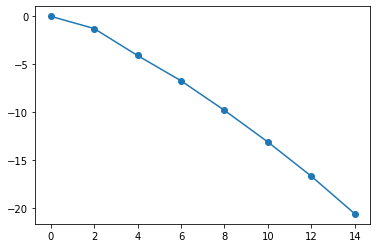

In [50]:
plt.plot(np.arange(0, 16, 2), alchemical_pots[:,0], '-o')

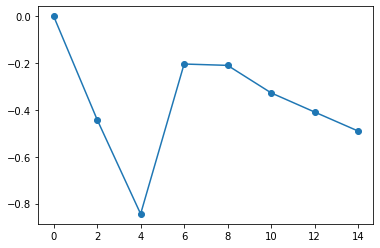

In [46]:
plt.plot(np.arange(0, 16, 2), ehomos, '-o')

In [36]:
get_atomic_energy(lam_vals[1:], alchemical_pots[1:,0], (e_nuc+0.35278480704256077)/2, ehomos[1:], 6, 6)*2

-91.93155985542651

In [39]:
lam_vals[1:]

array([0.14285714, 0.28571429, 0.42857143, 0.57142857, 0.71428571,
       0.85714286, 1.        ])

In [33]:
from ase.units import Bohr
d = 1.5/Bohr
1/d

0.35278480704256077

In [25]:
lam_vals = np.arange(8)*2/14

e_from_homo = get_atomic_energy(lam_vals, alchemical_pots[:,0], e_nuc/2, ehomos, 7, 7)*2
e_from_lumo = get_atomic_energy(lam_vals, alchemical_pots[:,0], e_nuc/2, elumos, 7, 7)*2

mean = (e_from_homo + e_from_lumo)/2

print(f'energy using homo = {e_from_homo}, delta E_ref = {e_from_homo - e_ref}')
print(f'energy using lumo = {e_from_lumo}, delta E_ref = {e_from_lumo - e_ref}')
print(f'energy using mean of homo and lumo = {mean}, delta E_ref = {mean - e_ref}')

energy using homo = -112.2671149635, delta E_ref = -3.56030336746727
energy using lumo = -105.41372728907564, delta E_ref = 3.2930843069570983
energy using mean of homo and lumo = -108.84042112628782, delta E_ref = -0.13360953025508593


### N$_2$ from diatomics with APDFT implementation

In [26]:
alchemical_pots2, ehomos2, elumos2, e_nuc2 = N2_APDFT()

12
TOTAL_ENERGY -1.0011014198648522
10
TOTAL_ENERGY -5.628524459617324
8
TOTAL_ENERGY -14.393211474040479
6
TOTAL_ENERGY -28.563023109075928
4
TOTAL_ENERGY -48.75621281463034
2
TOTAL_ENERGY -75.26768502575817
0
TOTAL_ENERGY -108.70681159603276


In [27]:
lam_vals = np.arange(8)*2/14
e_from_homo2 = get_atomic_energy(lam_vals, alchemical_pots2[:,0], e_nuc2/2, ehomos2, 7, 7)*2
e_from_lumo2 = get_atomic_energy(lam_vals, alchemical_pots2[:,0], e_nuc2/2, elumos2, 7, 7)*2
mean2 = (e_from_homo2 + e_from_lumo2)/2

print(f'energy using homo = {e_from_homo2}, delta E_ref = {e_from_homo2 - e_ref}')
print(f'energy using lumo = {e_from_lumo2}, delta E_ref = {e_from_lumo2 - e_ref}')
print(f'energy using mean of homo and lumo = {mean2}, delta E_ref = {mean2 - e_ref}')

energy using homo = -112.49942186758011, delta E_ref = -3.7926102715473746
energy using lumo = -106.63758746153964, delta E_ref = 2.0692241344930977
energy using mean of homo and lumo = -109.56850466455987, delta E_ref = -0.8616930685271313


### Atomisation energy

In [43]:
N_atoms()

/home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/pyscf/gto/mole.py:1047: UserWarning: Function mol.dumps drops attribute spin because it is not JSON-serializable
  warnings.warn(msg)


(array([list([]), list([]), list([]), list([]), list([]), list([]),
        list([]), list([])], dtype=object),
 array([ 0.        , -0.49980983, -0.91687015, -0.07925089, -0.30920635,
        -0.08587755, -0.35719238, -0.2026544 ]),
 array([0.        , 0.02708109, 0.82957977, 0.07829559, 0.05813838,
        0.04628395, 0.03382565, 0.02177696]),
 0)

In [44]:
el = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N']
energies = []
alchemical_potentials = []
e_homos = []
e_lumos = []

mol = pyscf.gto.Mole()
mol.atom = f'li 0 0 0'
mol.basis = 'def2-tzvp'
mol.verbose = 0
mol.spin = 1
mol.build()
calc = pyscf.scf.RHF(mol)
calc.kernel()
energies.append(calc.e_tot)
dm1_ao = calc.make_rdm1()
# get alchemical potential
# Electronic EPN from electron density
alch_pot_tmp = []
mol.set_rinv_orig_(mol.atom_coords()[0])
#         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
alch_pot_tmp.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())

# get ehomo
idx_homo = np.where(calc.get_occ()>0)[0][-1]
idx_lumo = idx_homo + 1
calc.mo_energy.sort()
e_homos.append(calc.mo_energy[idx_homo])
e_lumos.append(calc.mo_energy[idx_lumo])

In [28]:
el = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N']
energies = []
alchemical_potentials = []
e_homos = []
e_lumos = []
for e in el:
    mol = pyscf.gto.Mole()
    mol.atom = f'{e} 0 0 0; {e} 0 0 1.5'
    mol.basis = 'def2-tzvp'
    mol.verbose = 0
    mol.build()
    calc = pyscf.scf.RHF(mol)
    calc.kernel()
    energies.append(calc.e_tot)
    dm1_ao = calc.make_rdm1()
    # get alchemical potential
    # Electronic EPN from electron density
    alch_pot_tmp = []
    for site in [0,1]:
        mol.set_rinv_orig_(mol.atom_coords()[site])
#         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
        alch_pot_tmp.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
    alchemical_potentials.append(alch_pot_tmp)

    # get ehomo
    idx_homo = np.where(calc.get_occ()>0)[0][-1]
    idx_lumo = idx_homo + 1
    calc.mo_energy.sort()
    e_homos.append(calc.mo_energy[idx_homo])
    e_lumos.append(calc.mo_energy[idx_lumo])

In [29]:
calc.get_occ()

array([2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])